# Build ML models

- Read in the IS2 AGB trainig data.
- create a tindex of S1 boreal tiles
- using he tile num, reduce the IS2 training data to where we have S1
- Read in topo and HLS tindex and subset to whre we have S1

##### Note: Training data will contain point with a tile num that will match S1 tile id but it will be outside of S1 bounds. This is to include 'globabl' training at the individual tile scale

In [1]:
import pandas as pd
import geopandas as gpd
import glob
import os
import numpy as np
import rasterio as rio
import subprocess
print('packages imported')

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


packages imported


### Import the IS2 AGB training bank

In [3]:
training_feather = '/projects/shared-buckets/montesano/boreal_polar_map/tables/atl08_agb_train_tiles.feather'
df = pd.read_feather(training_feather)
df['tile_num_int'] = df['tile_num'].astype('int64')
print('original df has ' + str(len(df)) + ' rows')

original df has 41706828 rows


### Get list of Fall radar S1 data and create lists of useful params

In [4]:
s1_path = '/projects/my-public-bucket/sentinel1_seasonal_comps/S1_RTC_tindex/'

folders = ['Fall','Spring']

for folder in folders:
    if folder=='Fall':
        files = glob.glob(os.path.join(s1_path, folder +'/*.tif'))
        fall_tile_num = []
        fall_filenames = []
        fall_paths = []
        for file in files:
            fall_tile_num.append(int(file.split('/')[-1].split('_')[2]))
            fall_filenames.append(file.split('/')[-1])
            fall_paths.append(file)
    elif folder=='Spring':
        files = glob.glob(os.path.join(s1_path, folder +'/*.tif'))
        spring_tile_num = []
        spring_filenames = []
        spring_paths = []
        for file in files:
            spring_tile_num.append(int(file.split('/')[-1].split('_')[2]))
            spring_filenames.append(file.split('/')[-1])
            spring_paths.append(file)

print(spring_filenames)
print(fall_filenames)
#s1_df = pd.DataFrame({'filepath':paths, 'filename':filenames, 'tile_num':tile_num})
#s1_df.head()
#len(s1_df)

['s1_rtc_10_vvvh_Spring.tif', 's1_rtc_111_vvvh_Spring.tif', 's1_rtc_112_vvvh_Spring.tif', 's1_rtc_113_vvvh_Spring.tif', 's1_rtc_114_vvvh_Spring.tif', 's1_rtc_11_vvvh_Spring.tif', 's1_rtc_12_vvvh_Spring.tif', 's1_rtc_131_vvvh_Spring.tif', 's1_rtc_132_vvvh_Spring.tif', 's1_rtc_133_vvvh_Spring.tif', 's1_rtc_134_vvvh_Spring.tif', 's1_rtc_152_vvvh_Spring.tif', 's1_rtc_153_vvvh_Spring.tif', 's1_rtc_154_vvvh_Spring.tif', 's1_rtc_16_vvvh_Spring.tif', 's1_rtc_177_vvvh_Spring.tif', 's1_rtc_17_vvvh_Spring.tif', 's1_rtc_18_vvvh_Spring.tif', 's1_rtc_198_vvvh_Spring.tif', 's1_rtc_199_vvvh_Spring.tif', 's1_rtc_19_vvvh_Spring.tif', 's1_rtc_200_vvvh_Spring.tif', 's1_rtc_201_vvvh_Spring.tif', 's1_rtc_222_vvvh_Spring.tif', 's1_rtc_223_vvvh_Spring.tif', 's1_rtc_224_vvvh_Spring.tif', 's1_rtc_225_vvvh_Spring.tif', 's1_rtc_247_vvvh_Spring.tif', 's1_rtc_248_vvvh_Spring.tif', 's1_rtc_249_vvvh_Spring.tif', 's1_rtc_27_vvvh_Spring.tif', 's1_rtc_31_vvvh_Spring.tif', 's1_rtc_3271_vvvh_Spring.tif', 's1_rtc_3272_vvvh

### Subset the IS2 AGB df if we have corresponding S1 tile num

In [5]:
print("subset IS2 df based on S1 tile ids")
sub_df = df[df['tile_num_int'].isin(fall_tile_num)]
print(np.sort(np.unique(sub_df['tile_num_int'])))

print('df has ' + str(len(sub_df)) + ' rows')

subset IS2 df based on S1 tile ids
[   4    9   10   11   12   16   17   18   19   27   31   37   38   39
   41   42   43   47   48   49   50   52   53   54   58   59   60   61
   72   73   94  111  112  113  131  132  133  152  153  154  177  198
  199  200  201  222  223  224  225  247  248  249  355  356  386  387
  388  418  419 3271 3272 3273 3363 3364 3365 3366 3367 3455 3456 3457
 3458 3459 3460 3461 3550 3551 3552 3553 3554 3555 3556 3644 3645 3646
 3647 3648 3649]
df has 763251 rows


### Create a gdf of the IS2 points for covar extraction

In [6]:
sub_gdf = gpd.GeoDataFrame(
    sub_df, geometry=gpd.points_from_xy(sub_df.lon, sub_df.lat), crs='EPSG:4326')
print(sub_gdf.head())

#sub_gdf.to_file('/projects/my-public-bucket/sentinel1_seasonal_comps/sub_gdf.gpkg', driver='GPKG')

             lon        lat         AGB        SE tile_num  tile_num_int  \
287471  6.944713  58.303544  108.670335  0.001075     0010            10   
287472  6.981278  58.207990   11.443054  0.001203     0010            10   
287473  8.541175  58.509150   35.422381  0.001075     0010            10   
287474  7.052336  58.575449   11.564917  0.001075     0010            10   
287475  8.675406  58.913518   26.539087  0.001203     0010            10   

                        geometry  
287471  POINT (6.94471 58.30354)  
287472  POINT (6.98128 58.20799)  
287473  POINT (8.54117 58.50915)  
287474  POINT (7.05234 58.57545)  
287475  POINT (8.67541 58.91352)  


### Training tiles: A list f the tile nums where we have data

### Load the topo and hls tindex

In [7]:
# load topo tindex
Topo_mosaic_fn  = '/projects/my-public-bucket/DPS_tile_lists/Topo_tindex_master.csv'
topo = pd.read_csv(Topo_mosaic_fn)
sub_topo = topo[topo['tile_num'].isin(fall_tile_num)]

# load HLS index
HLS_mosaic_fn  = '/projects/my-public-bucket/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_tindex_master.csv'
hls = pd.read_csv(HLS_mosaic_fn)
sub_hls = hls[hls['tile_num'].isin(fall_tile_num)]

sub_hls.head()

,Unnamed: 0,Unnamed: 0.1,s3_path,local_path,file,tile_num
121,65,31,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,HLS_3364_06-01_09-15_2019_2021.tif,3364
125,69,27,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,HLS_112_06-01_09-15_2019_2021.tif,112
142,86,10,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,HLS_3272_06-01_09-15_2019_2021.tif,3272
143,87,9,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,HLS_48_06-01_09-15_2019_2021.tif,48
150,94,2,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,HLS_225_06-01_09-15_2019_2021.tif,225


### create Vrts of the tiles for point extraction

In [16]:
hls_paths = sub_hls['local_path'].to_list()
topo_paths = sub_topo['local_path'].to_list()
s1_fall_paths = fall_paths
s1_spring_paths = spring_paths

hls_vrt = '/projects/my-public-bucket/sentinel1_seasonal_comps/VRTs/HLS_IS2_vrt.vrt'
topo_vrt = '/projects/my-public-bucket/sentinel1_seasonal_comps/VRTs/TOPO_IS2_vrt.vrt'
s1_fall_vrt = '/projects/my-public-bucket/sentinel1_seasonal_comps/VRTs/S1_IS2_FALL_vrt.vrt'
s1_spring_vrt = '/projects/my-public-bucket/sentinel1_seasonal_comps/VRTs/S1_IS2_SPRING_vrt.vrt'

if False:
    subprocess.call(' '.join(['gdalbuildvrt', hls_vrt] + hls_paths),shell=True)
    subprocess.call(' '.join(['gdalbuildvrt', topo_vrt] + topo_paths),shell=True)
    subprocess.call(' '.join(['gdalbuildvrt', s1_fall_vrt] + s1_fall_paths),shell=True)
    subprocess.call(' '.join(['gdalbuildvrt', s1_spring_vrt] + s1_spring_paths),shell=True)



0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


### Get CRS of imagery to use as master CRS

In [17]:
with rio.open(s1_fall_vrt) as f:
    master_crs = f.crs
    
master_crs

CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

### Reproj IS2 gdf to same crs as covars

In [18]:
sub_gdf_proj = sub_gdf.to_crs(master_crs)

### extract covars to IS2 df

In [19]:
# get x,y locations
coord_list = [(x,y) for x,y in zip(sub_gdf_proj['geometry'].x , sub_gdf_proj['geometry'].y)]

In [21]:
# sample the vrts using the x,y locations
if False:
    print('Sampling topo...')
    topo_src = rio.open(topo_vrt)
    sub_gdf_proj['topo_covar'] = [x for x in topo_src.sample(coord_list)]
    print('Finished')

    print('Sampling hls...')
    hls_src = rio.open(hls_vrt)
    sub_gdf_proj['hls_covar'] = [x for x in hls_src.sample(coord_list)]
    print('Finished')

    print('Sampling fall s1...')
    s1_fall_src = rio.open(s1_fall_vrt)
    sub_gdf_proj['s1_fall_covar'] = [x for x in s1_fall_src.sample(coord_list)]
    print('Finished')

    print('Sampling spring s1...')
    s1_spring_src = rio.open(s1_spring_vrt)
    sub_gdf_proj['s1_spring_covar'] = [x for x in s1_spring_src.sample(coord_list)]
    print('Finished')

Sampling topo...
Finished


#### Split the lists extracted by src.sample up into individual columns

In [22]:
sub_gdf_proj['elevation'] = [x[0] for x in sub_gdf_proj['topo_covar']]
sub_gdf_proj['slope'] = [x[1] for x in sub_gdf_proj['topo_covar']]
sub_gdf_proj['tsri'] = [x[2] for x in sub_gdf_proj['topo_covar']]
sub_gdf_proj['tpi'] = [x[3] for x in sub_gdf_proj['topo_covar']]
sub_gdf_proj['slope_mask'] = [x[4] for x in sub_gdf_proj['topo_covar']]

sub_gdf_proj['blue'] = [x[0] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['green'] = [x[1] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['red'] = [x[2] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['nir'] = [x[3] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['swir'] = [x[4] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['swir2'] = [x[5] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['ndvi'] = [x[6] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['savi'] = [x[7] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['msavi'] = [x[8] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['ndmi'] = [x[9] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['evi'] = [x[4] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['nbr'] = [x[10] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['nbr2'] = [x[11] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['tcb'] = [x[12] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['tcg'] = [x[13] for x in sub_gdf_proj['hls_covar']]
sub_gdf_proj['tcw'] = [x[14] for x in sub_gdf_proj['hls_covar']]

sub_gdf_proj['vv_fall'] = [x[0] for x in sub_gdf_proj['s1_fall_covar']]
sub_gdf_proj['vh_fall'] = [x[1] for x in sub_gdf_proj['s1_fall_covar']]

sub_gdf_proj['vv_spring'] = [x[0] for x in sub_gdf_proj['s1_spring_covar']]
sub_gdf_proj['vh_spring'] = [x[1] for x in sub_gdf_proj['s1_spring_covar']]




#### Drop the coar lists

In [23]:
sub_gdf_proj = sub_gdf_proj.drop(['topo_covar', 'hls_covar', 's1_fall_covar', 's1_spring_covar'], axis=1)

#### Remove zeros to reduce the data to where we only have valid S1 data

In [25]:
sub_gdf_proj = sub_gdf_proj[sub_gdf_proj['vv_fall']>0]

#### Convert S1 to db units

In [31]:
sub_gdf_proj['vv_fall_db'] = 10*np.log10(sub_gdf_proj['vv_fall'])
sub_gdf_proj['vh_fall_db'] = 10*np.log10(sub_gdf_proj['vh_fall'])
sub_gdf_proj['vv_spring_db'] = 10*np.log10(sub_gdf_proj['vv_spring'])
sub_gdf_proj['vh_spring_db'] = 10*np.log10(sub_gdf_proj['vh_spring'])

#### write to GPKG

In [41]:
sub_gdf_proj_4326 = sub_gdf_proj.to_crs('EPSG:4326')

In [42]:
sub_gdf_proj_4326.to_file('/projects/my-public-bucket/sentinel1_seasonal_comps/IS2_AGB_CoVars_training_s1.gpkg', driver='GPKG')

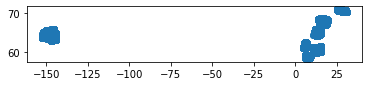

In [43]:
sub_gdf_proj_4326.plot()

,lon,lat,AGB,SE,tile_num,tile_num_int,geometry,elevation,slope,tsri,...,tcg,tcw,vv_fall,vh_fall,vv_spring,vh_spring,vv_fall_db,vh_fall_db,vv_spring_db,vh_spring_db
287471,6.944713,58.303544,108.670335,0.001075,0010,10,POINT (-2081273.860 9192083.093),11.690205,6.911824,0.461431,...,0.219431,0.240048,0.123201,0.030401,0.106778,0.027224,-9.093846,-15.171074,-9.715164,-15.650456
287472,6.981278,58.207990,11.443054,0.001203,0010,10,POINT (-2088845.237 9200057.707),374.015564,6.466940,0.894134,...,0.272507,0.259743,0.101544,0.030397,0.117073,0.027667,-9.933438,-15.171671,-9.315430,-15.580442
287473,8.541175,58.509150,35.422381,0.001075,0010,10,POINT (-2145725.372 9122392.534),156.643097,20.723127,0.519634,...,0.165595,0.170754,0.157074,0.047012,0.175254,0.048996,-8.038956,-13.277913,-7.563322,-13.098364
287474,7.052336,58.575449,11.564917,0.001075,0010,10,POINT (-2070030.441 9162839.792),461.456512,8.078266,0.999326,...,0.282242,0.250962,0.109208,0.026812,0.092610,0.019654,-9.617460,-15.716705,-10.333415,-17.065559
287476,6.960767,58.100499,65.062633,0.008893,0010,10,POINT (-2094346.573 9210942.104),32.583660,11.026880,0.745768,...,0.322008,0.320757,0.208911,0.047254,0.159392,0.063567,-6.800391,-13.255622,-7.975332,-11.967664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41706462,-144.676529,64.134824,4.667318,0.001203,0225,225,POINT (1618791.092 3122708.153),492.176392,5.915209,0.304363,...,0.277536,0.252923,0.157135,0.041806,0.087734,0.018979,-8.037276,-13.787599,-10.568332,-17.217365
41706464,-146.520936,62.933722,16.825646,0.001075,0225,225,POINT (1606545.747 2959984.641),877.207458,9.359911,0.243640,...,0.294354,0.254843,0.064984,0.013836,0.051199,0.007151,-11.871930,-18.589745,-12.907392,-21.456090
41706494,-149.310157,65.035941,9.164867,0.001075,0225,225,POINT (1377758.348 3109174.742),93.919228,0.711308,0.159242,...,0.276067,0.244414,0.119058,0.032951,0.088257,0.023042,-9.242422,-14.821351,-10.542484,-16.374708
41706627,-145.165420,65.271523,3.677342,0.001075,0225,225,POINT (1534777.694 3222575.196),432.987274,3.069923,0.995804,...,0.259394,0.182122,0.111455,0.027403,0.049822,0.007044,-9.528988,-15.622085,-13.025767,-21.522073
